# Mobile money transactions Fraud Detection

Objective: Use SQL to explore and detect anomalies in financial transactions

Steps:
1. Import and Understand the data
2. SQL Investigations
3. Summary of findings
4. Next Steps

## Step 1: About Dataset

PaySim is a financial simulator that simulates mobile money transactions based on an original dataset. PaySim was run several times using random seeds for 744 steps, representing one month of real time data.

PaySim simulator:
E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

Link to the dataset
https://www.kaggle.com/datasets/ealaxi/paysim1

Columns and their description:

| Column Name    | Description                                            |
| -------------- | ------------------------------------------------------ |
| step           | Hour of the simulation (1–744)                         |
| type           | Type of transaction (TRANSFER, CASH_OUT, DEBIT, etc.) |
| amount         | Amount of money transferred                            |
| nameOrig       | ID of sender                                           |
| oldbalanceOrg  | Sender’s balance before transaction                    |
| newbalanceOrig | Sender’s balance after transaction                     |
| nameDest       | ID of recipient                                        |
| oldbalanceDest | Recipient’s balance before transaction                 |
| newbalanceDest | Recipient’s balance after transaction                  |
| isFraud        | 1 if transaction is fraud, else 0                      |
| isFlaggedFraud | 1 if system flagged it as fraud                        |



Types of Transactions:
- CASH-IN is the process of increasing the balance of account by paying in cash to a merchant
- CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account
- DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account
- PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
- TRANSFER is the process of sending money to another user of the service through the mobile money platform.

NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

While the author makes the above note, I observed that certain transactions even when not flagged as fraud, didn't have origin and destination balances that made logical sense.
For example, I noticed that for a cash out transaction , one can only withdraw the maximum he/she has in that account. Also, in types of transfers such as cash_out or cash_in, there cannot be values for destination account, because there is just one account involved. These questions were asked by some folks on kaggle but the author hasn't replied.

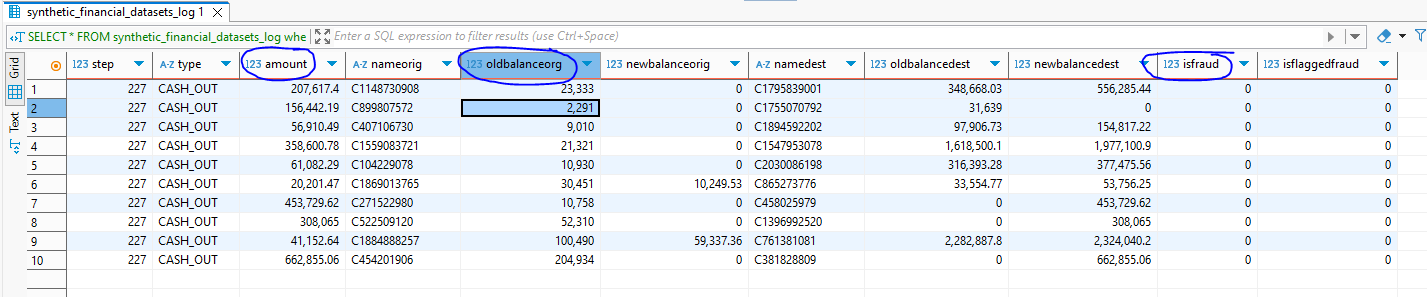

Having made the observation and noted it , I will continue with the data analysis with the dataset as is. I imported it to a Tbale named synthetic_financial_datasets_log in DBeaver. 


## Step 2: SQL Investigations
1. How big is fraud?
2. What type of transactions constituted fraud?
3. Did current system in place identify fraud transactions as fraudulent?
4. Since steps are hours - are there certain times when there is more fraudulent activity than others?
5. is there a spike in activity for certain accounts?
6. Are there Outliers? - high stakes.

### Q1 How big is fraud?
- no. of transactions
- $ amount

In [ ]:
SELECT 
  isfraud,
  COUNT(*) AS transactions,
  ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct_total
FROM synthetic_financial_datasets_log 
GROUP BY isfraud;

IndentationError: unexpected indent (4265176205.py, line 2)


|isfraud|transactions|pct_total|
|-------|------------|---------|
|0|6354407|99.87|
|1|8213|0.13|


In [ ]:
SELECT 
  isfraud, 
  SUM(amount) AS total_amount, 
  AVG(amount) AS avg_amount,
  MAX(amount) AS max_amount  
FROM synthetic_financial_datasets_log 
GROUP BY isfraud;

|isfraud|total_amount|avg_amount|max_amount|
|-------|------------|----------|----------|
|0|1120574504960|178197.04173539375|92445520|
|1|12056465408|1467967.299835128|10000000|

only 0.13% of the transactions are fraud transactions but that amounts to 12 Billion $. Average transaction amount for a fraud transaction is about 10 times higher than non-fraud transaction. Transaction higher than $200,000  could be flagged. 

### Q2 What type of transactions are fraud?

In [ ]:
SELECT 
  type,
  COUNT(*) AS total_transactions,
  SUM(isfraud) AS fraud_transactions,
  ROUND(100.0 * SUM(isfraud) / COUNT(*), 2) AS fraud_rate_pct
FROM synthetic_financial_datasets_log 
GROUP BY type
ORDER BY fraud_rate_pct DESC;


|type|total_transactions|fraud_transactions|fraud_rate_pct|
|----|------------------|------------------|--------------|
|TRANSFER|532909|4097|0.77|
|CASH_OUT|2237500|4116|0.18|
|CASH_IN|1399284|0|0.00|
|DEBIT|41432|0|0.00|
|PAYMENT|2151495|0|0.00|


Out of the 5 different transaction types, TRANSFER and CASH_OUT are the types of transactions fraudsters use. Primarily Transfer. 
Questions that follow to flag certain accounts:
- When transfers are made, are there certain accounts that recieve fraud money more than others?
- What accounts makes these transactions?
- Do any accounts transfer fraud money as well as recieve fraud money? 
- are these accounts used more than once for fraud? Origin, destination
- When the transfer is made, is the account drained
- When cash out is done, is the account drained?

#### Brief look at the accounts associated with fraud of the total 8213

In [ ]:
SELECT 
  count(*) as total,
  count(distinct nameorig) as orig,
  count(distinct namedest ) as dest
FROM synthetic_financial_datasets_log 
WHERE isfraud = 1 
;

|total|orig|dest|
|-----|----|----|
|8213|8213|8169|
|


Out of 8213 transactions associated with fraud, all of them have unique accounts that are used to create fraud transaction, but 8169 are destination accounts. Meaning couple of accounts have been used more than once to make transactions into.  

#### Destination and Origin Accounts that are associated with fraud

In [ ]:
SELECT DISTINCT nameorig AS account
  FROM synthetic_financial_datasets_log 
  WHERE isfraud = 1
  union 
  SELECT DISTINCT namedest AS account
  FROM synthetic_financial_datasets_log
  WHERE isfraud = 1
LIMIT 10;

|account|
|-------|
|C1499429209|
|C1783297640|
|C489647033|
|C946777990|
|C964511313|
|C459414804|
|C1044355469|
|C780743034|
|C29820940|
|C120055626|


Just a list of 10 out of the 8213

#### Accounts that are associated with fraud more than once

In [ ]:
SELECT * FROM ( 
SELECT 
  distinct namedest,
  COUNT(*) AS fraud_received_count,
  SUM(amount) AS fraud_received_amt
FROM synthetic_financial_datasets_log 
WHERE isfraud = 1 
GROUP BY namedest
ORDER BY fraud_received_amt desc)
WHERE fraud_received_count>1
;

|namedest|fraud_received_count|fraud_received_amt|
|--------|--------------------|------------------|
|C668046170|2|10160089|
|C1669818195|2|8848240.0|
|C1981613973|2|7265502.0|
|C1366192319|2|7061799.5|
|C964377943|2|6014862.0|
|C14138104|2|4597314.0|
|C1399829166|2|3540009.2|
|C643624257|2|3071717.0|
|C1013511446|2|2994972.0|
|C1601170327|2|2842695.0|
|C52390890|2|2662695.5|
|C104038589|2|2202770.0|
|C803116137|2|1744765.8|
|C904300960|2|1427683.1|
|C967226405|2|1416085.5|
|C385133759|2|1396377.2|
|C1259079602|2|1214480.4|
|C644163395|2|1196176.1|
|C1827800010|2|1140481.0|
|C185805228|2|1124385.0|
|C1653587362|2|1059054.0|
|C2129197098|2|991012.5|
|C1837027614|2|951189.9|
|C1827219533|2|907503.2|
|C1497532505|2|744832.5|
|C475338087|2|730733.5|
|C1780714769|2|717835.2|
|C686334805|2|629142.75|
|C2020337583|2|579140.9|
|C935310781|2|544064.5|
|C1656842502|2|524000.72|
|C105660024|2|514468.66|
|C1148781766|2|499556.75|
|C650699445|2|408028.62|
|C1193568854|2|397486.0|
|C1325541393|2|350800.28|
|C1185292292|2|225576.16|
|C1655359478|2|179543.44|
|C505532836|2|174238.22|
|C1980653895|2|134287.3|
|C410033330|2|133781.84|
|C1650668671|2|46972.832|
|C1460854172|2|38626.668|
|C200064275|2|8847.0|


About 44 accounts

#### Are accounts associated with fraud more than once, more daring with their $?

In [ ]:
SELECT 
fraud_received_count,
SUM(fraud_received_amt)
FROM ( 
SELECT 
  distinct namedest,
  COUNT(*) AS fraud_received_count,
  SUM(amount) AS fraud_received_amt
FROM synthetic_financial_datasets_log 
WHERE isfraud = 1 
GROUP BY namedest
ORDER BY fraud_received_amt desc)
GROUP BY fraud_received_count
;

|fraud_received_count|sum|
|--------------------|---|
|1|11972964352|
|2|83413824|


Looks like that is not the case. Instead, fraud accounts are mostly single use. 

#### Are there accounts acting as origin and destination?

In [ ]:
SELECT DISTINCT nameorig AS account
  FROM synthetic_financial_datasets_log 
  WHERE isfraud = 1
  intersect 
  SELECT DISTINCT namedest AS account
  FROM synthetic_financial_datasets_log
  WHERE isfraud = 1;

Empty. Looks like there no accounts both initiates and receives fraud in this dataset. This data doesn't show possible money laundering accounts that are used to layer money or obscure the trail.

#### Do origin accounts drain their account when doing fraud transaction?

In [ ]:
 SELECT 
  COUNT(*) 
FROM synthetic_financial_datasets_log
WHERE isfraud = 1 
  AND newbalanceorig = 0
  AND amount = oldbalanceorg;

|count|
|-----|
|8024|


Out of the total 8213 accounts, nearly all of them (8024) drain their accounts. Making them very suspicious and could be used to flag the transaction/account for early warning signals . However, it is important to remember that this dataset has problems with origin and destination balances even when they are not fraud transactions. 

### Q3 Did current system in place identify fraud transactions as fraudulent?

In [ ]:
SELECT 
  isfraud, SUM(isfraud) AS total_fraud ,
  SUM(CASE WHEN isflaggedfraud = 1 THEN 1 ELSE 0 END) AS flagged,
  ROUND(100.0 * SUM(CASE WHEN isflaggedfraud = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS flag_rate_pct
FROM synthetic_financial_datasets_log  
GROUP BY isfraud;

|isfraud|total_fraud|flagged|flag_rate_pct|
|-------|-----------|-------|-------------|
|0|0|0|0.00|
|1|8213|16|0.19|


Clearly not working. less than 1%. Also to note that the system didn't flag any non-fraud transactions as fraud.

### Q4 Since steps are hours - are there certain times when there is more fraudulent activity than others?

In [ ]:
SELECT 
  step % 24 AS hour_of_day,
  COUNT(*) AS total_transactions,
  SUM(isfraud) AS fraud_transactions,
  ROUND(100.0 * SUM(isfraud) / COUNT(*), 2) AS fraud_pct
FROM synthetic_financial_datasets_log
GROUP BY hour_of_day
ORDER BY fraud_pct DESC;

|hour_of_day|total_transactions|fraud_transactions|fraud_pct|
|-----------|------------------|------------------|---------|
|5|1641|366|22.30|
|4|1241|274|22.08|
|3|2007|326|16.24|
|6|3420|358|10.47|
|2|9018|372|4.13|
|7|8988|328|3.65|
|8|26915|368|1.37|
|1|27111|358|1.32|
|0|71587|300|0.42|
|23|141257|323|0.23|
|22|194555|351|0.18|
|21|247806|347|0.14|
|9|283518|341|0.12|
|10|425729|375|0.09|
|14|439653|353|0.08|
|15|416686|341|0.08|
|16|441612|345|0.08|
|17|439941|353|0.08|
|11|445992|324|0.07|
|13|468474|346|0.07|
|12|483418|339|0.07|
|18|580509|343|0.06|
|20|553728|340|0.06|
|19|647814|342|0.05|


Looks like early hours of the day from about 3-6 am looks like the busiest hours for fraud transactions

### Q5 Spike in activity

In [ ]:
WITH txn_with_moving_avg AS (
  SELECT 
    nameorig,
    step,
    amount,
    AVG(amount) OVER (
      PARTITION BY nameorig
      ORDER BY step
      ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS moving_avg_3hr,
    isfraud
  FROM synthetic_financial_datasets_log  
),
spikes AS (
  SELECT nameorig, isfraud 
  FROM txn_with_moving_avg
  WHERE amount > 2 * moving_avg_3hr
)
SELECT 
  nameorig, isfraud,
  COUNT(*) AS spike_count
FROM spikes
GROUP BY nameorig, isfraud
ORDER BY spike_count DESC
LIMIT 10;

|nameorig|isfraud|spike_count|
|--------|-------|-----------|
|C1462946854|0|1|
|C400299098|0|1|
|C545315117|0|1|


Yes, couple of accounts showed spike in activity - which has been defined as transaction amount being more than 2 times that of past 3 hr average. However, could be used to flag users and prevent account misuse. 

### Q6 Are there any outliers?
- top highest transaction amounts
- away from 3 SD from mean

### Take a look at 10 transactions with the highest transaction amount

In [ ]:
SELECT 
  nameorig,
  namedest,
  amount
FROM synthetic_financial_datasets_log 
WHERE isfraud = 1 
ORDER BY amount DESC
LIMIT 10;

|nameorig|namedest|amount|
|--------|--------|------|
|C1028530067|C1390461904|10000000|
|C180127057|C2029456603|10000000|
|C487836667|C1825256816|10000000|
|C844374854|C141316671|10000000|
|C150617765|C1641778666|10000000|
|C1849235881|C1877706055|10000000|
|C1790027985|C243227440|10000000|
|C1721880478|C521374455|10000000|
|C2022162818|C1201081149|10000000|
|C1723333662|C1093911640|10000000|


lots of transactions with 10 million transaction amount

In [ ]:
SELECT 
amount, COUNT(*)
FROM synthetic_financial_datasets_log 
WHERE isfraud = 1 
GROUP BY amount
ORDER BY amount DESC
LIMIT 10;

|amount|count|
|------|-----|
|10000000|287|
|9996887.0|2|
|9977761.0|2|
|9960382.0|2|
|9887819.0|2|
|9811104.0|2|
|9772559.0|2|
|9749043.0|2|
|9725837.0|2|
|9639525.0|2|


In [ ]:
WITH fraud_stats AS (
  SELECT 
    ROUND(AVG(amount)) AS avg_fraud,
    ROUND(STDDEV(amount)) AS stddev_fraud
  FROM synthetic_financial_datasets_log
  WHERE isfraud = 1
)
SELECT 
  t.nameOrig,
  t.nameDest,
  t.amount,
  f.avg_fraud,
  f.stddev_fraud
FROM synthetic_financial_datasets_log t, fraud_stats f
WHERE t.isfraud = 1 
  AND t.amount > f.avg_fraud + 3 * f.stddev_fraud
ORDER BY t.amount DESC
LIMIT 10;

|nameorig|namedest|amount|avg_fraud|stddev_fraud|
|--------|--------|------|---------|------------|
|C2022162818|C1201081149|10000000|1467967.0|2404253.0|
|C150617765|C1641778666|10000000|1467967.0|2404253.0|
|C1790027985|C243227440|10000000|1467967.0|2404253.0|
|C1849235881|C1877706055|10000000|1467967.0|2404253.0|
|C487836667|C1825256816|10000000|1467967.0|2404253.0|
|C180127057|C2029456603|10000000|1467967.0|2404253.0|
|C844374854|C141316671|10000000|1467967.0|2404253.0|
|C1028530067|C1390461904|10000000|1467967.0|2404253.0|
|C1723333662|C1093911640|10000000|1467967.0|2404253.0|
|C1721880478|C521374455|10000000|1467967.0|2404253.0|


In [ ]:
SELECT COUNT(*) 
FROM ( 
SELECT 
  nameorig,
  namedest,
  amount,
  (SELECT AVG(amount) FROM synthetic_financial_datasets_log WHERE isFraud = 1) AS avg_fraud,
  (SELECT STDDEV(amount) FROM synthetic_financial_datasets_log WHERE isFraud = 1) AS stddev_fraud
FROM synthetic_financial_datasets_log sfdl 
WHERE isFraud = 1 
)
where amount > (avg_fraud + 3* stddev_fraud )
;

|count|
|-----|
|368|


There are lots of transactions that fall outside of 3 standard deviations from mean. looks like a right fat tail data

## Step 3: Conclusions
1. Fradulent transactions tend to be of higher dollar value. The average fraud amount was significantly higher than non-fraud amount. In this dataset, lots of transactions at 10million dollars indicating large single transfers
2. Combined with single use origin and destination accounts, fraudsters could be attempting at 'big score' frauds than multiple smaller ones
3. Fraud is contentrated in specific type of transactions. In this dataset, it happends with transfers and cashouts. Could be that money is being transferred and then cashed out
4. The fraud transactions happen to clear their accounts all at once
5. By applying rolling window analysis, we could look at sudden spike in transaction activity, however, this dataset doesn't seem to exhibit sudden spikes just before or during fraudulent actiivties- just the one activity and exit. However, it could serve as an early warning signal.
6. There is list of nameorig and namedest accounts that are resposnible for the fraud transactions. These accounts need to be flagged - can help prevent repeat offenders
7. Flagging transactions that are way above the average $ value could be useful defense mechanism. 

## Step 4: Next Steps:
- Can use the above conclusions to build a user level anomaly score (transaction amount, type of transaction, hour of operation ) to build an early warning indicator.
- Tableau dashboard showing a view of fraud accounts, heatmap of fraud across steps , explore flagged transactions by user, type, amount, and time
- Use these features to build a machine learning fraud classifier, improving detection without too many false positives.